In [1]:
import time
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Layer
import numpy
import matplotlib.pyplot as plt
import pandas
import os 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model, load_model
from tqdm import trange
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Embedding, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop


from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
import datetime
from scipy.stats import pearsonr
from tensorflow import keras
from keras import layers
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
DATA_DIR = 'Mumu.csv'
# load the dataset
#使用 pandas 库的 read_csv 函数从指定路径 datasource 加载 csv 格式的数据。
d= pandas.read_csv(DATA_DIR)
d.columns = ["Id", "Time", "CPU", "Mem","Net-in","Net-out","Desk-io"]
# print(d)

df1=d[d['Id']=='m_1934']
dataset_1=df1[['CPU']]
#fillna 函数是 Pandas 库中用来处理缺失数据的函数。
#将缺失的数据点以前面的数据点填充，这里指定 method='pad'，也就是用前面的数据点填充。
dataset_1 = dataset_1.fillna(method='pad')
#将 dataframe 转换为一个 NumPy 数组，保存到 dataset 中。
dataset_1 = dataset_1.values
#将 dataset 中的数据类型转换为 float32
dataset_1 = dataset_1.astype('float32')
# print(dataset_1.shape)

dataset_2=df1[['Mem']]
#fillna 函数是 Pandas 库中用来处理缺失数据的函数。
#将缺失的数据点以前面的数据点填充，这里指定 method='pad'，也就是用前面的数据点填充。
dataset_2 = dataset_2.fillna(method='pad')
#将 dataframe 转换为一个 NumPy 数组，保存到 dataset 中。
dataset_2 = dataset_2.values
#将 dataset 中的数据类型转换为 float32
dataset_2 = dataset_2.astype('float32')
# print(dataset_2.shape)

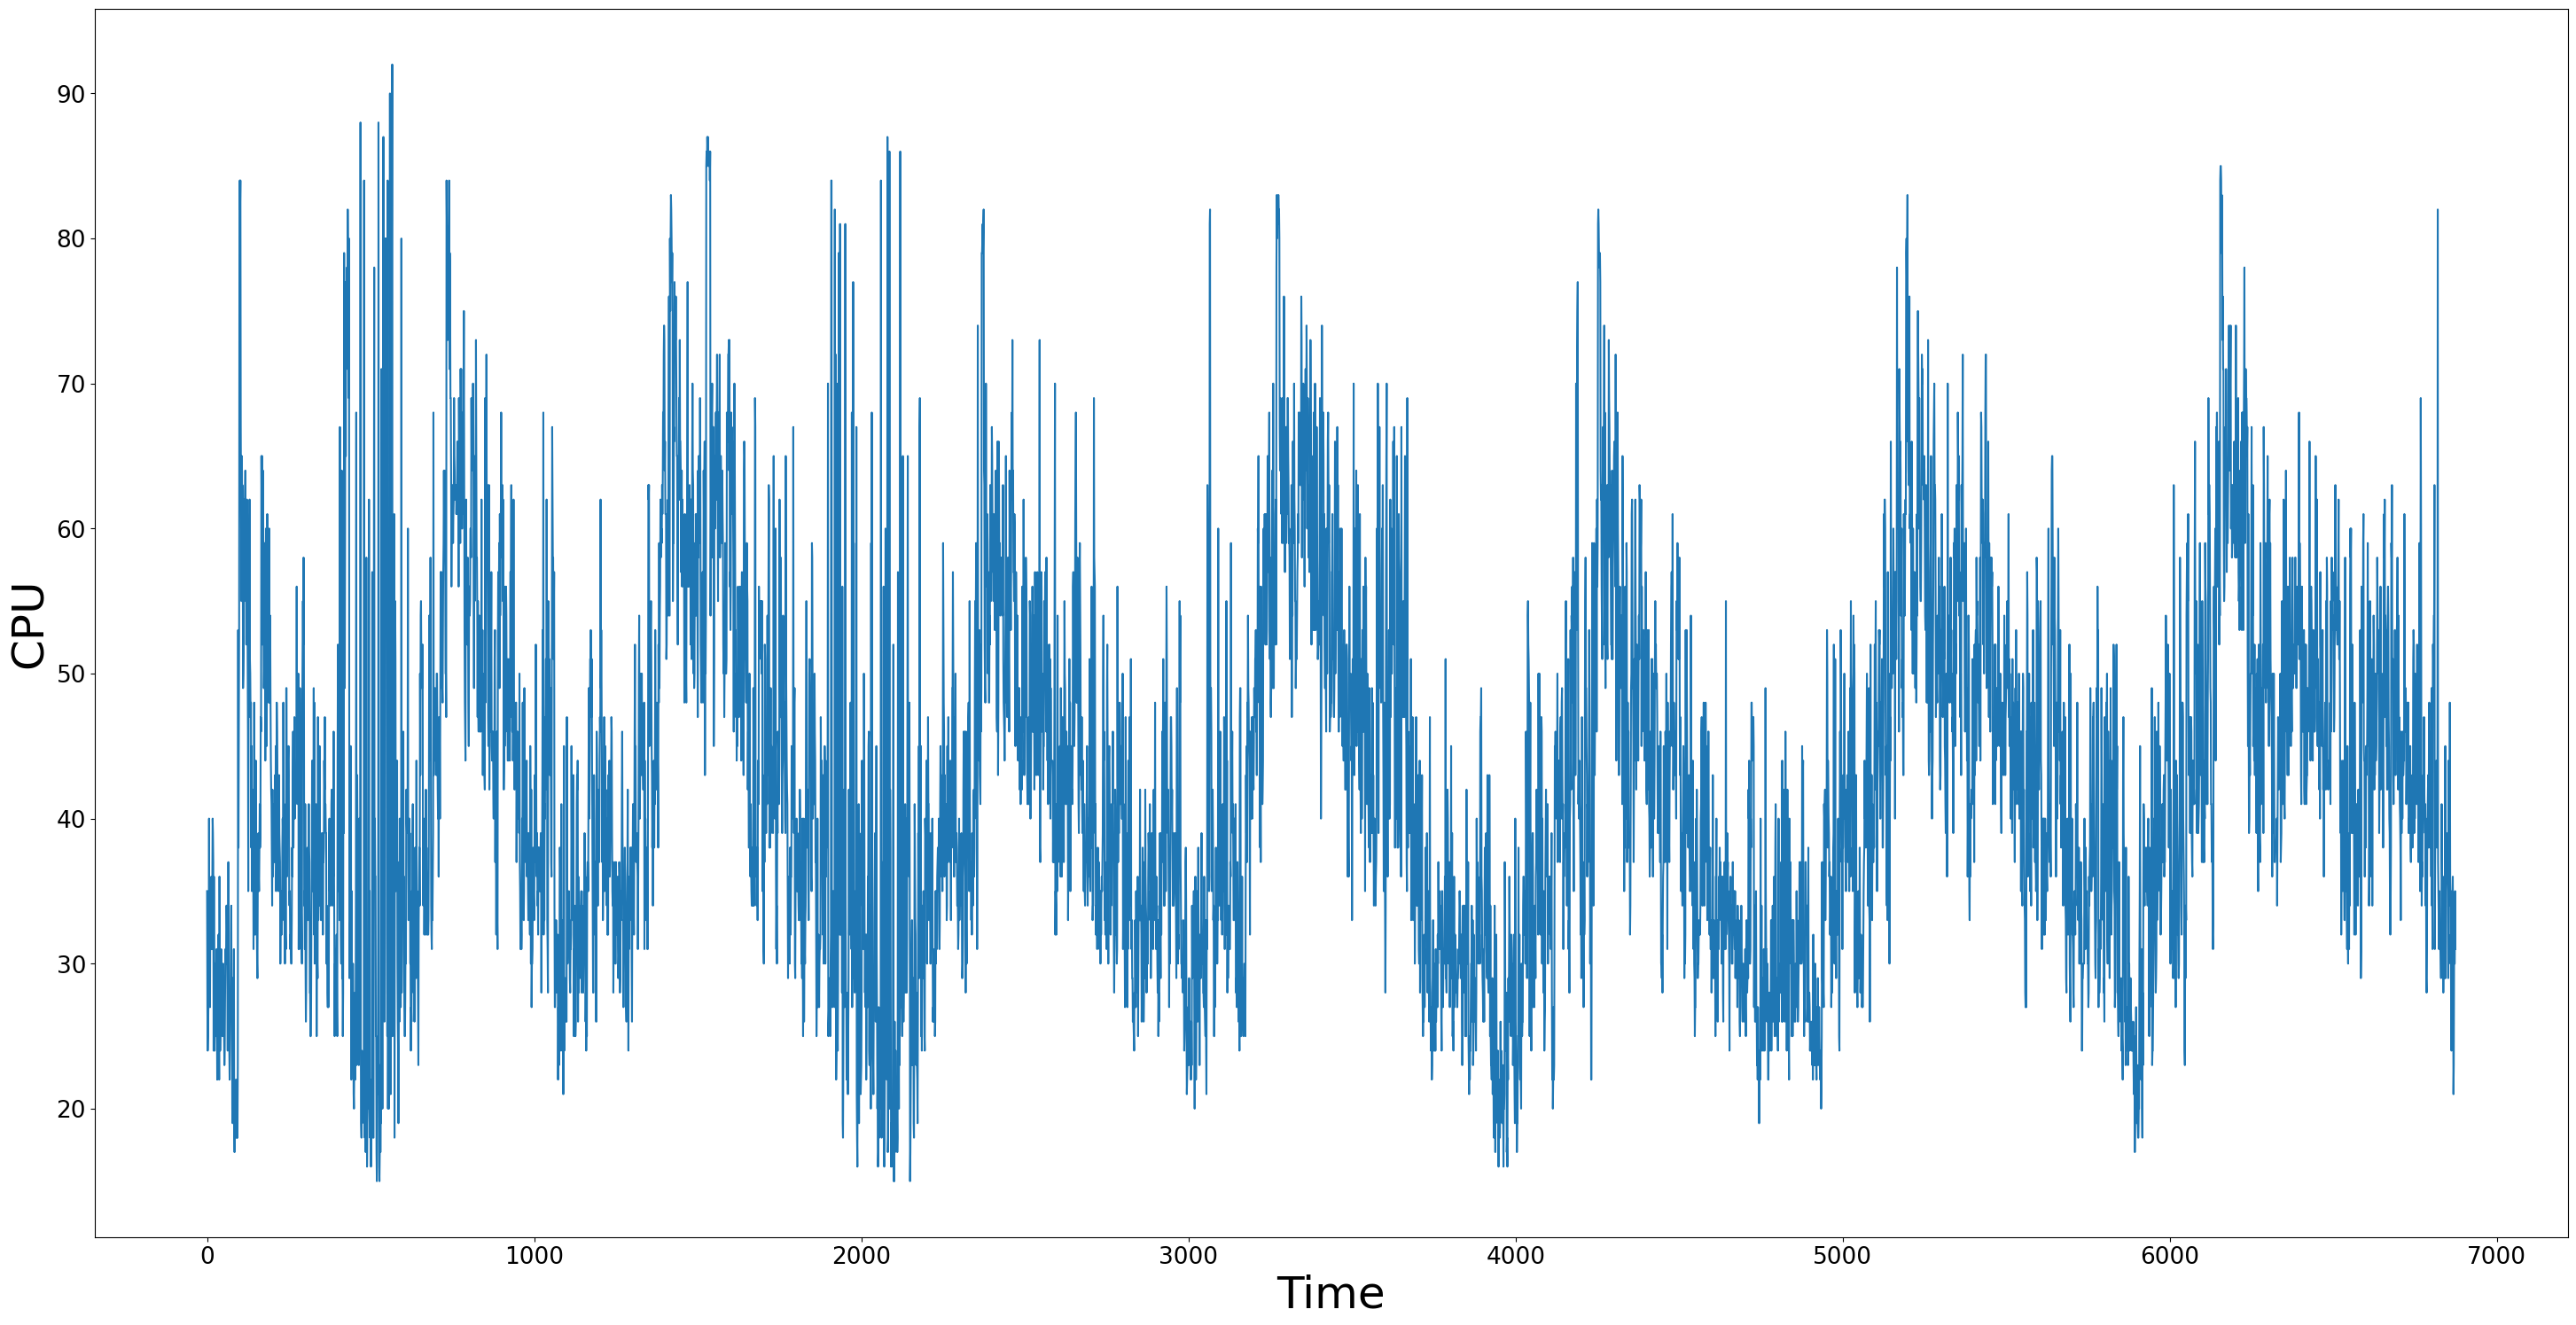

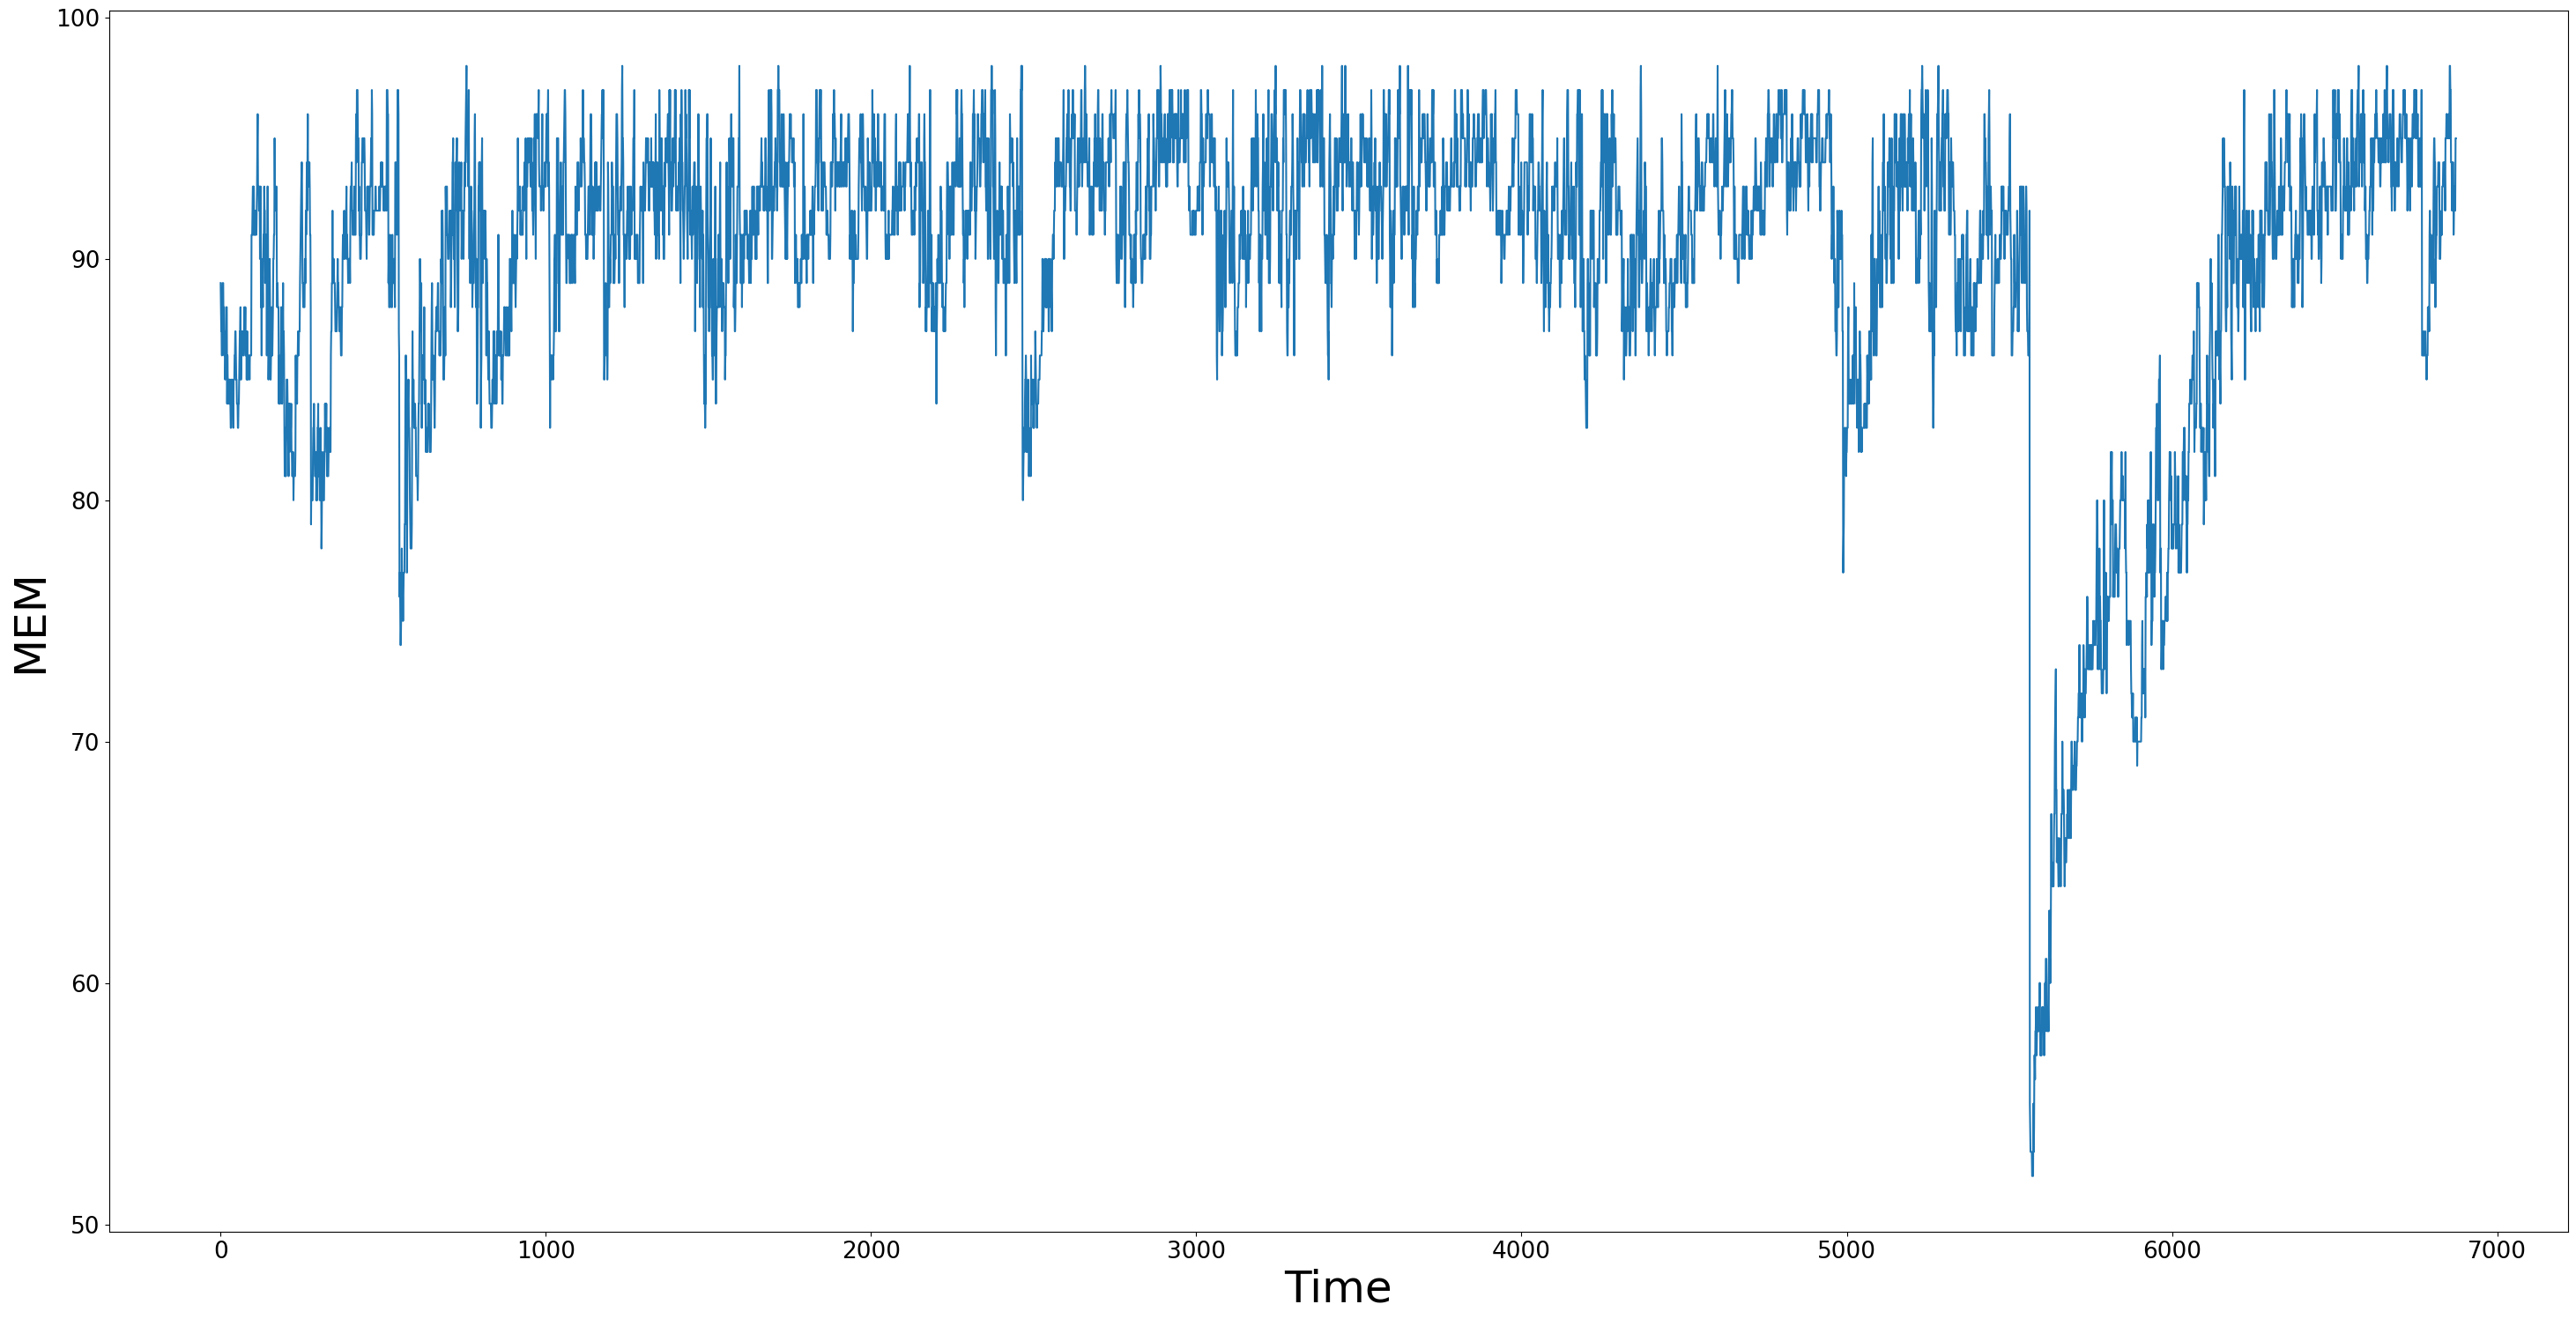

In [3]:
def plot_dataset(Dataset: str,X,Y):
    plt.figure(figsize = (36,18))
    plt.tick_params(labelsize=19)
    #plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
    #给当前图表添加一个 x 轴标签，标签内容为 'Date_Time'，字体大小为 18。
    plt.xlabel(X,fontsize=36)
    #给当前图表添加一个 y 轴标签，标签内容为 'Close Price'，字体大小为 18。
    plt.ylabel(Y,fontsize=36)
    plt.plot(range(Dataset.shape[0]),Dataset)
    plt.show()
    return plt.show()
#CPU
plot_dataset(dataset_1,"Time","CPU")
#MEM
plot_dataset(dataset_2,"Time","MEM")

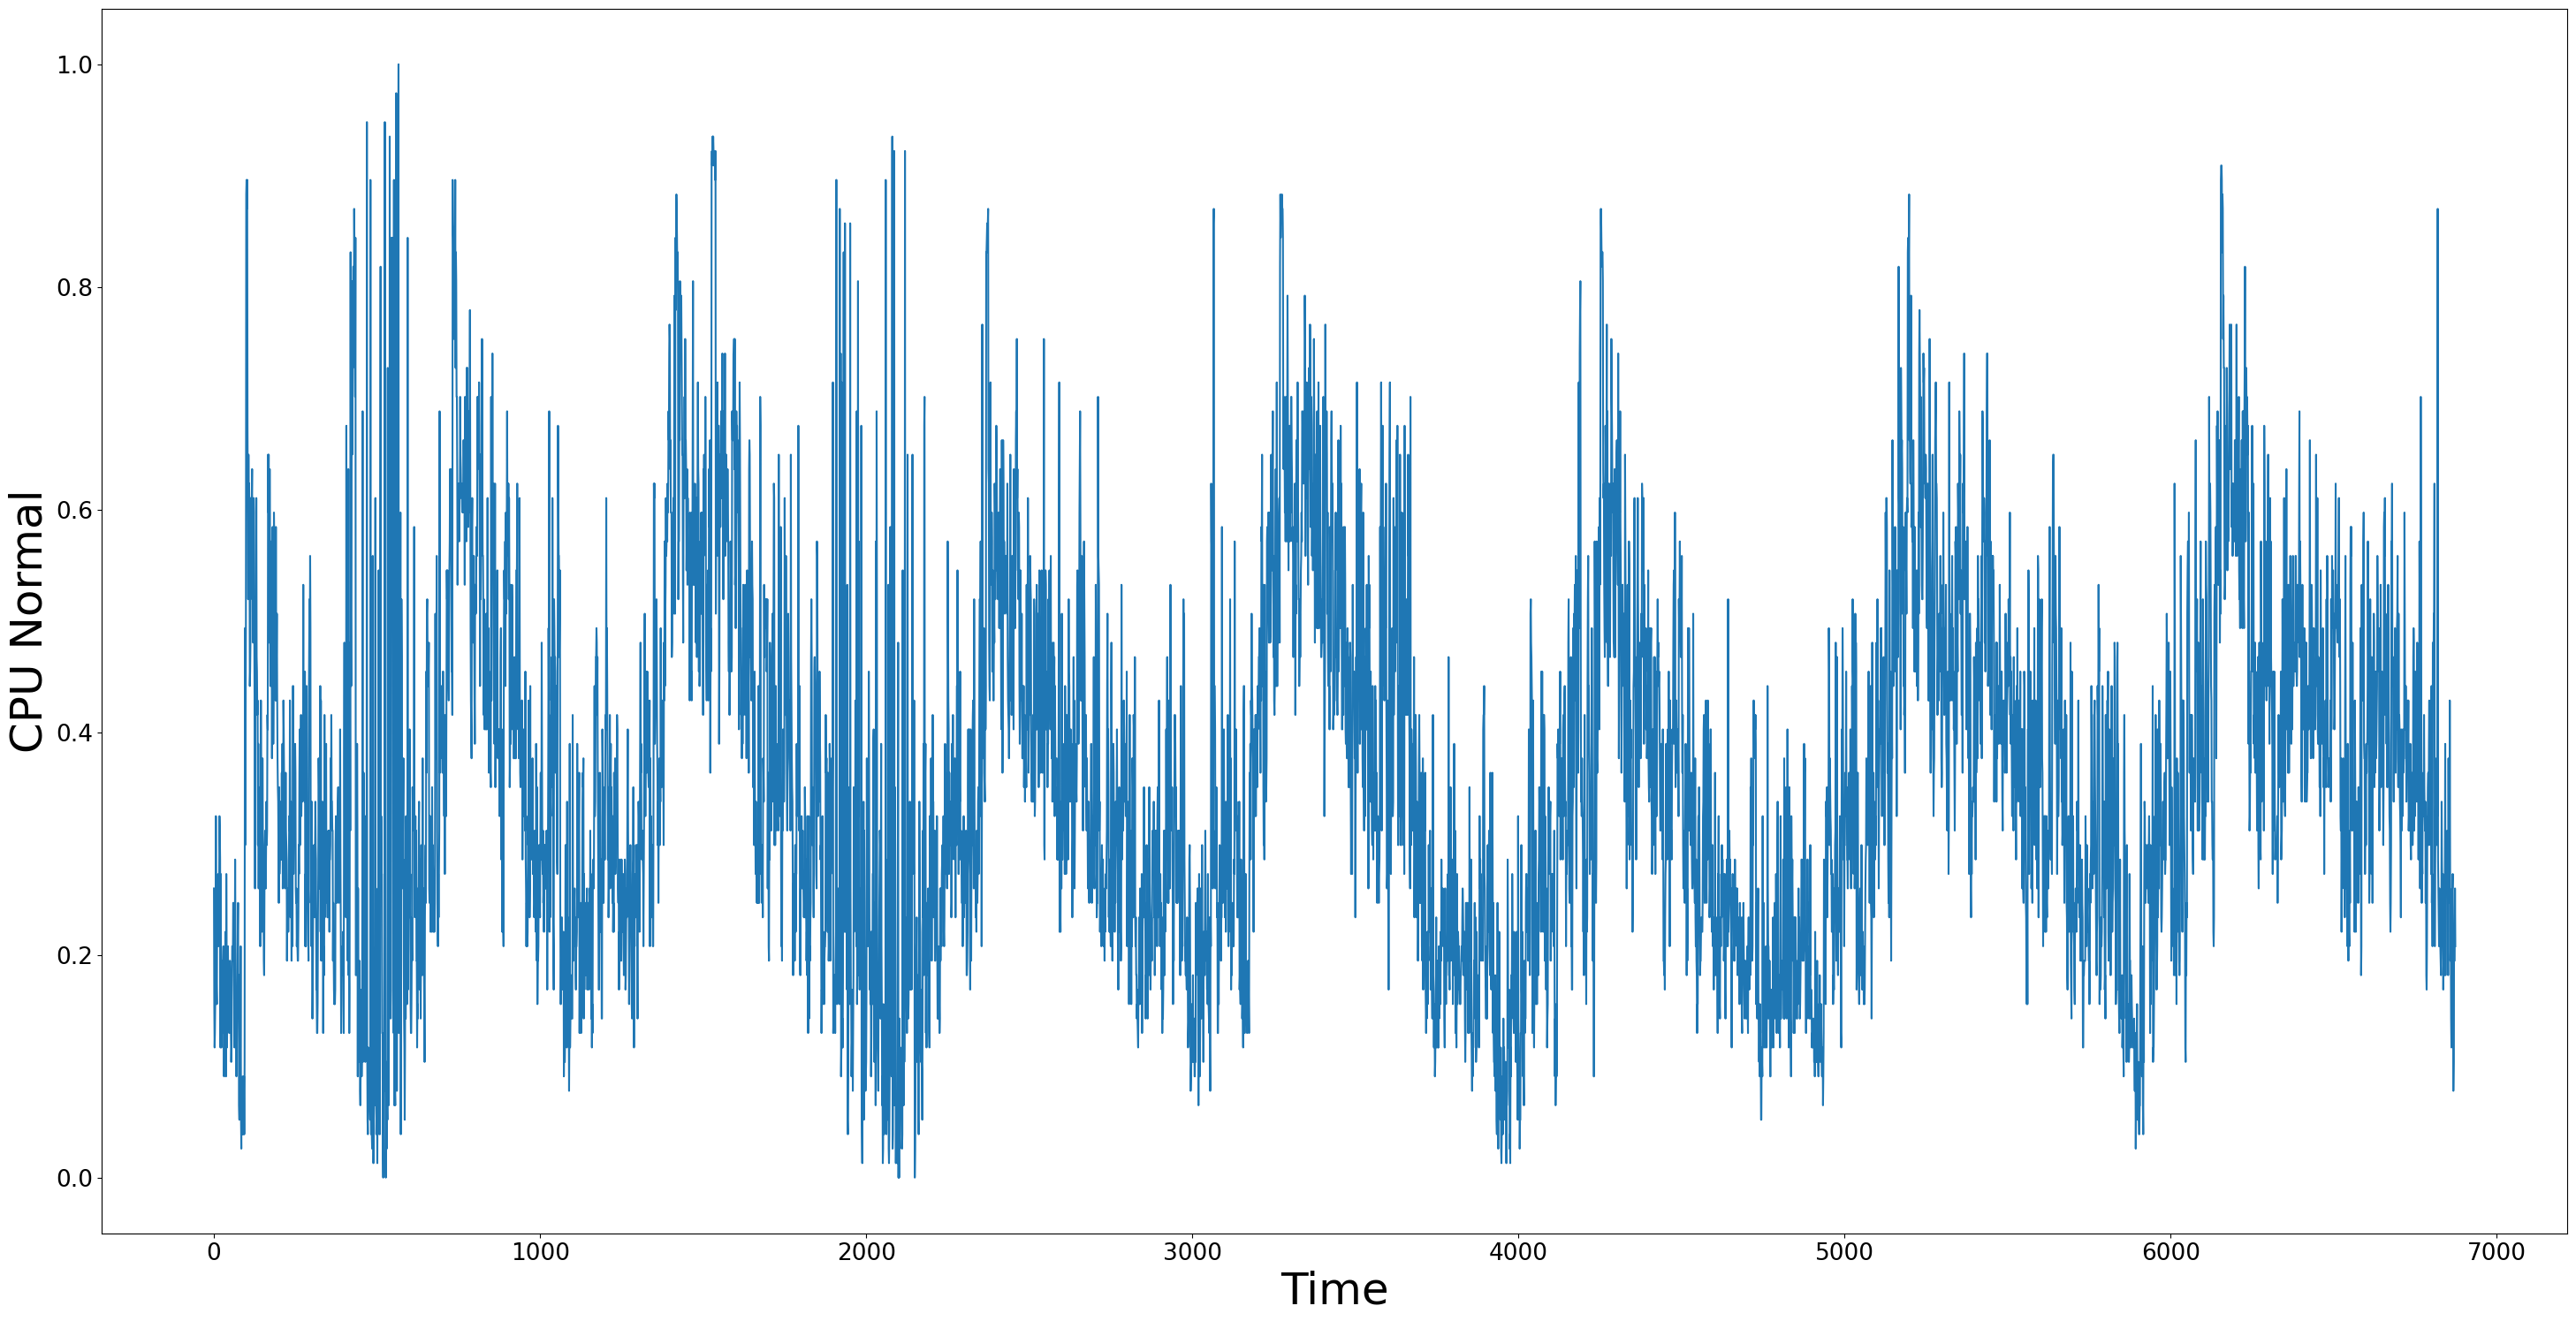

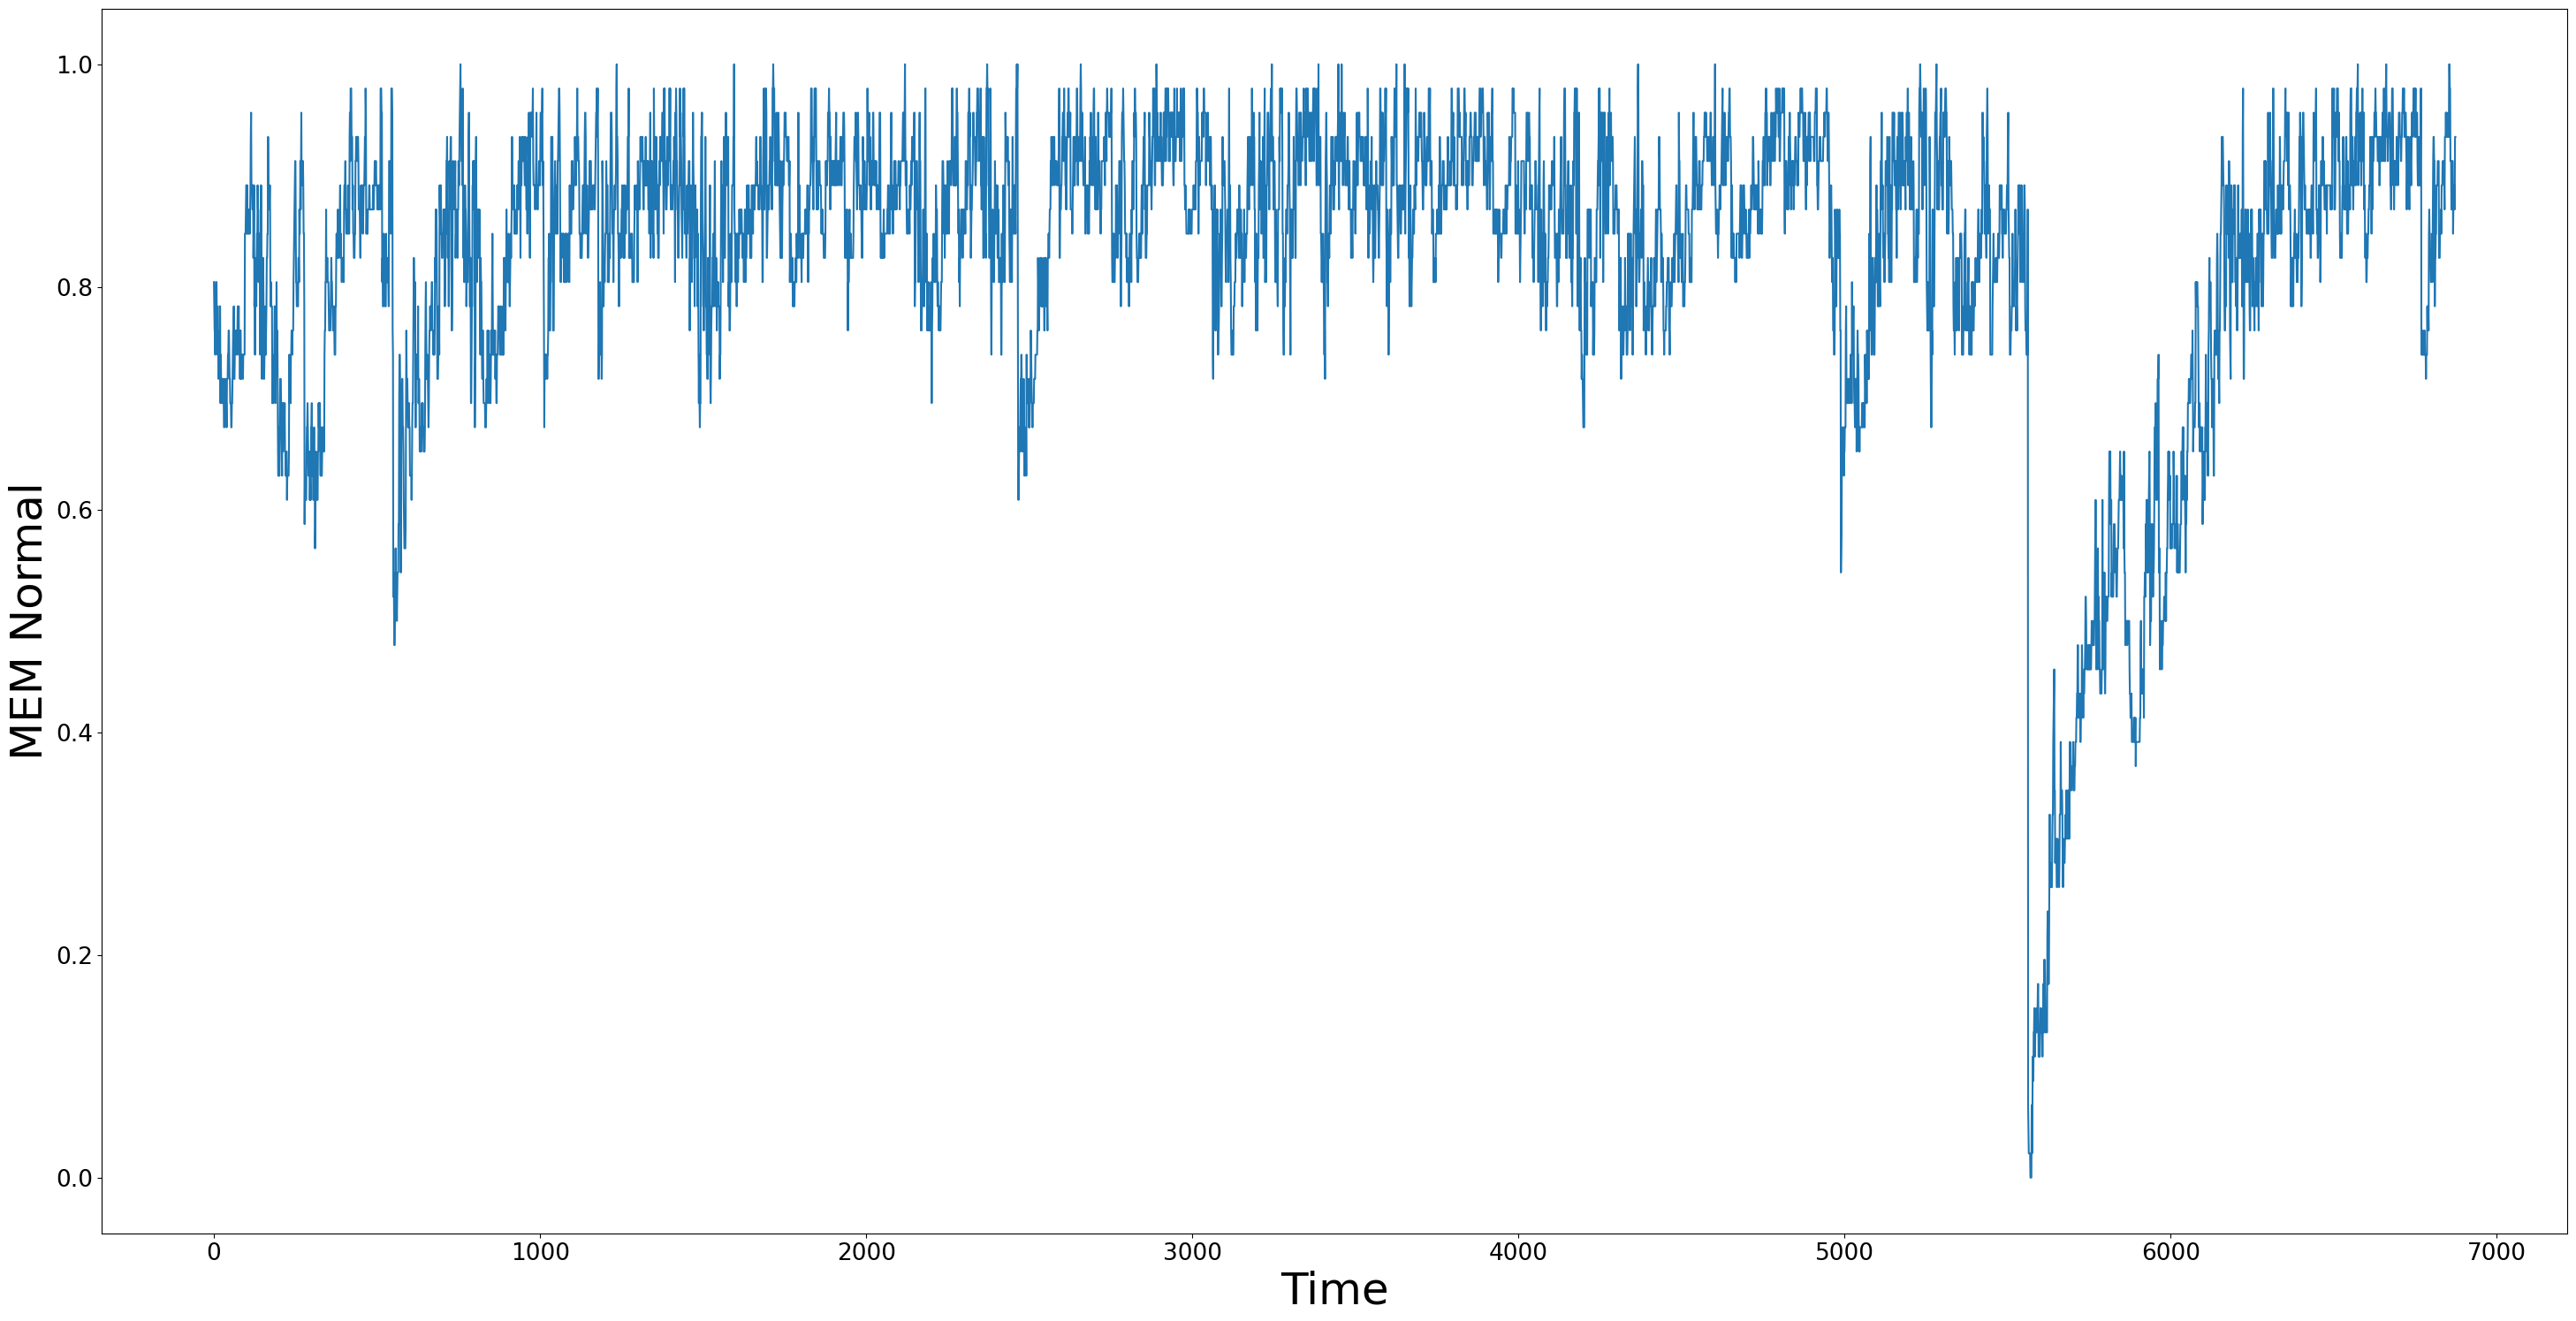

In [4]:
# normalize the dataset
#将数据缩放到0到1之间。
scaler_1 = MinMaxScaler(feature_range=(0, 1)).fit(dataset_1)
scaler_2 = MinMaxScaler(feature_range=(0, 1)).fit(dataset_2)
#fit_transform()方法在拟合数据的同时对数据进行缩放并返回缩放后的数组。
#dataset = scaler.fit_transform(dataset)
Dataset_1 = scaler_1.transform(dataset_1)
Dataset_2 = scaler_2.transform(dataset_2)
# plot_dataset(Dataset_1,time,"Time","CPU Normal")
# plot_dataset(Dataset_2,time,"Time","MEM Normal")
plot_dataset(Dataset_1,"Time","CPU Normal")
plot_dataset(Dataset_2,"Time","MEM Normal")

In [5]:
def split_dataset(dataset, iltrain) :
    split = int(len(dataset) * iltrain)
    #取 dataset 数组中第 0 行到第 train_size-1 行的所有列数据，作为训练集。 
    #取 dataset 数组中从第 train_size-look_back 行到最后一行的所有列，即测试集。
    train = dataset[:split]
    test = dataset[split:]
    #train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    print('train_dataset: {}, test_dataset: {}'.format(len(train), len(test)))
    return train, test
#CPU
train_dataset , test_dataset = split_dataset(Dataset_1 , 0.8)
##MEM
train_dataset2 , test_dataset2 = split_dataset(Dataset_2 , 0.8)

train_dataset: 5499, test_dataset: 1375
train_dataset: 5499, test_dataset: 1375


In [6]:
SEQ_LEN = 64            
# How far into the future we are making prediction(10 min in this case)
#用未来10个单位的时间来预测当前的股价变化。
FUTURE_PERIOD = 16
#指定要预测的是什么变量。
RATIO_TO_PREDICT = "CPU"

def create_dataset(dataset: numpy.ndarray):
    data_x = []
    data_y = []
    for i in range(len(dataset)-FUTURE_PERIOD):
        #提取从第 i 行到第 i+look_back-1 行（即长度为 look_back）的第 0 列数据。第一维度切片！
        a = dataset[i:(i+FUTURE_PERIOD), 0]
        data_x.append(a)
        #提取第 i+look_back 行的第0列数据，用作训练数据对应的标签。
        b = dataset[(i + FUTURE_PERIOD), 0]    #最终y少了最前面的 look_back个数据
        data_y.append(b)
    #返回值是一个元组，包含两个 NumPy 数组。
    #第一个数组 X 是输入特征，其形状为 (samples, look_back, features)，samples代表样本数，look_back代表每个样本包含的时间步数，features 代表每个时间步的特征数。
    #第二个数组 y 是输出标签，其形状为 (samples, 1)，其中 samples 代表样本数，1 代表每个样本的输出值。
    return numpy.array(data_x), numpy.array(data_y) 
#CPU
train_x,train_y = create_dataset(train_dataset)    
test_x,test_y = create_dataset(test_dataset)
#MEM
train_x2,train_y2 = create_dataset(train_dataset2)    
test_x2,test_y2 = create_dataset(test_dataset2)

In [7]:
train_x = numpy.reshape(train_x, (train_x.shape[0] , train_x.shape[1], 1))
test_x = numpy.reshape(test_x, (test_x.shape[0] , test_x.shape[1], 1))
train_y = numpy.reshape(train_y, (train_y.shape[0] ))
test_y = numpy.reshape(test_y, (test_y.shape[0]))
#MEM
train_x2 = numpy.reshape(train_x2, (train_x2.shape[0] , train_x2.shape[1], 1))
test_x2 = numpy.reshape(test_x2, (test_x2.shape[0] , test_x2.shape[1], 1))
train_y2 = numpy.reshape(train_y2, (train_y2.shape[0] ))
test_y2 = numpy.reshape(test_y2, (test_y2.shape[0]))

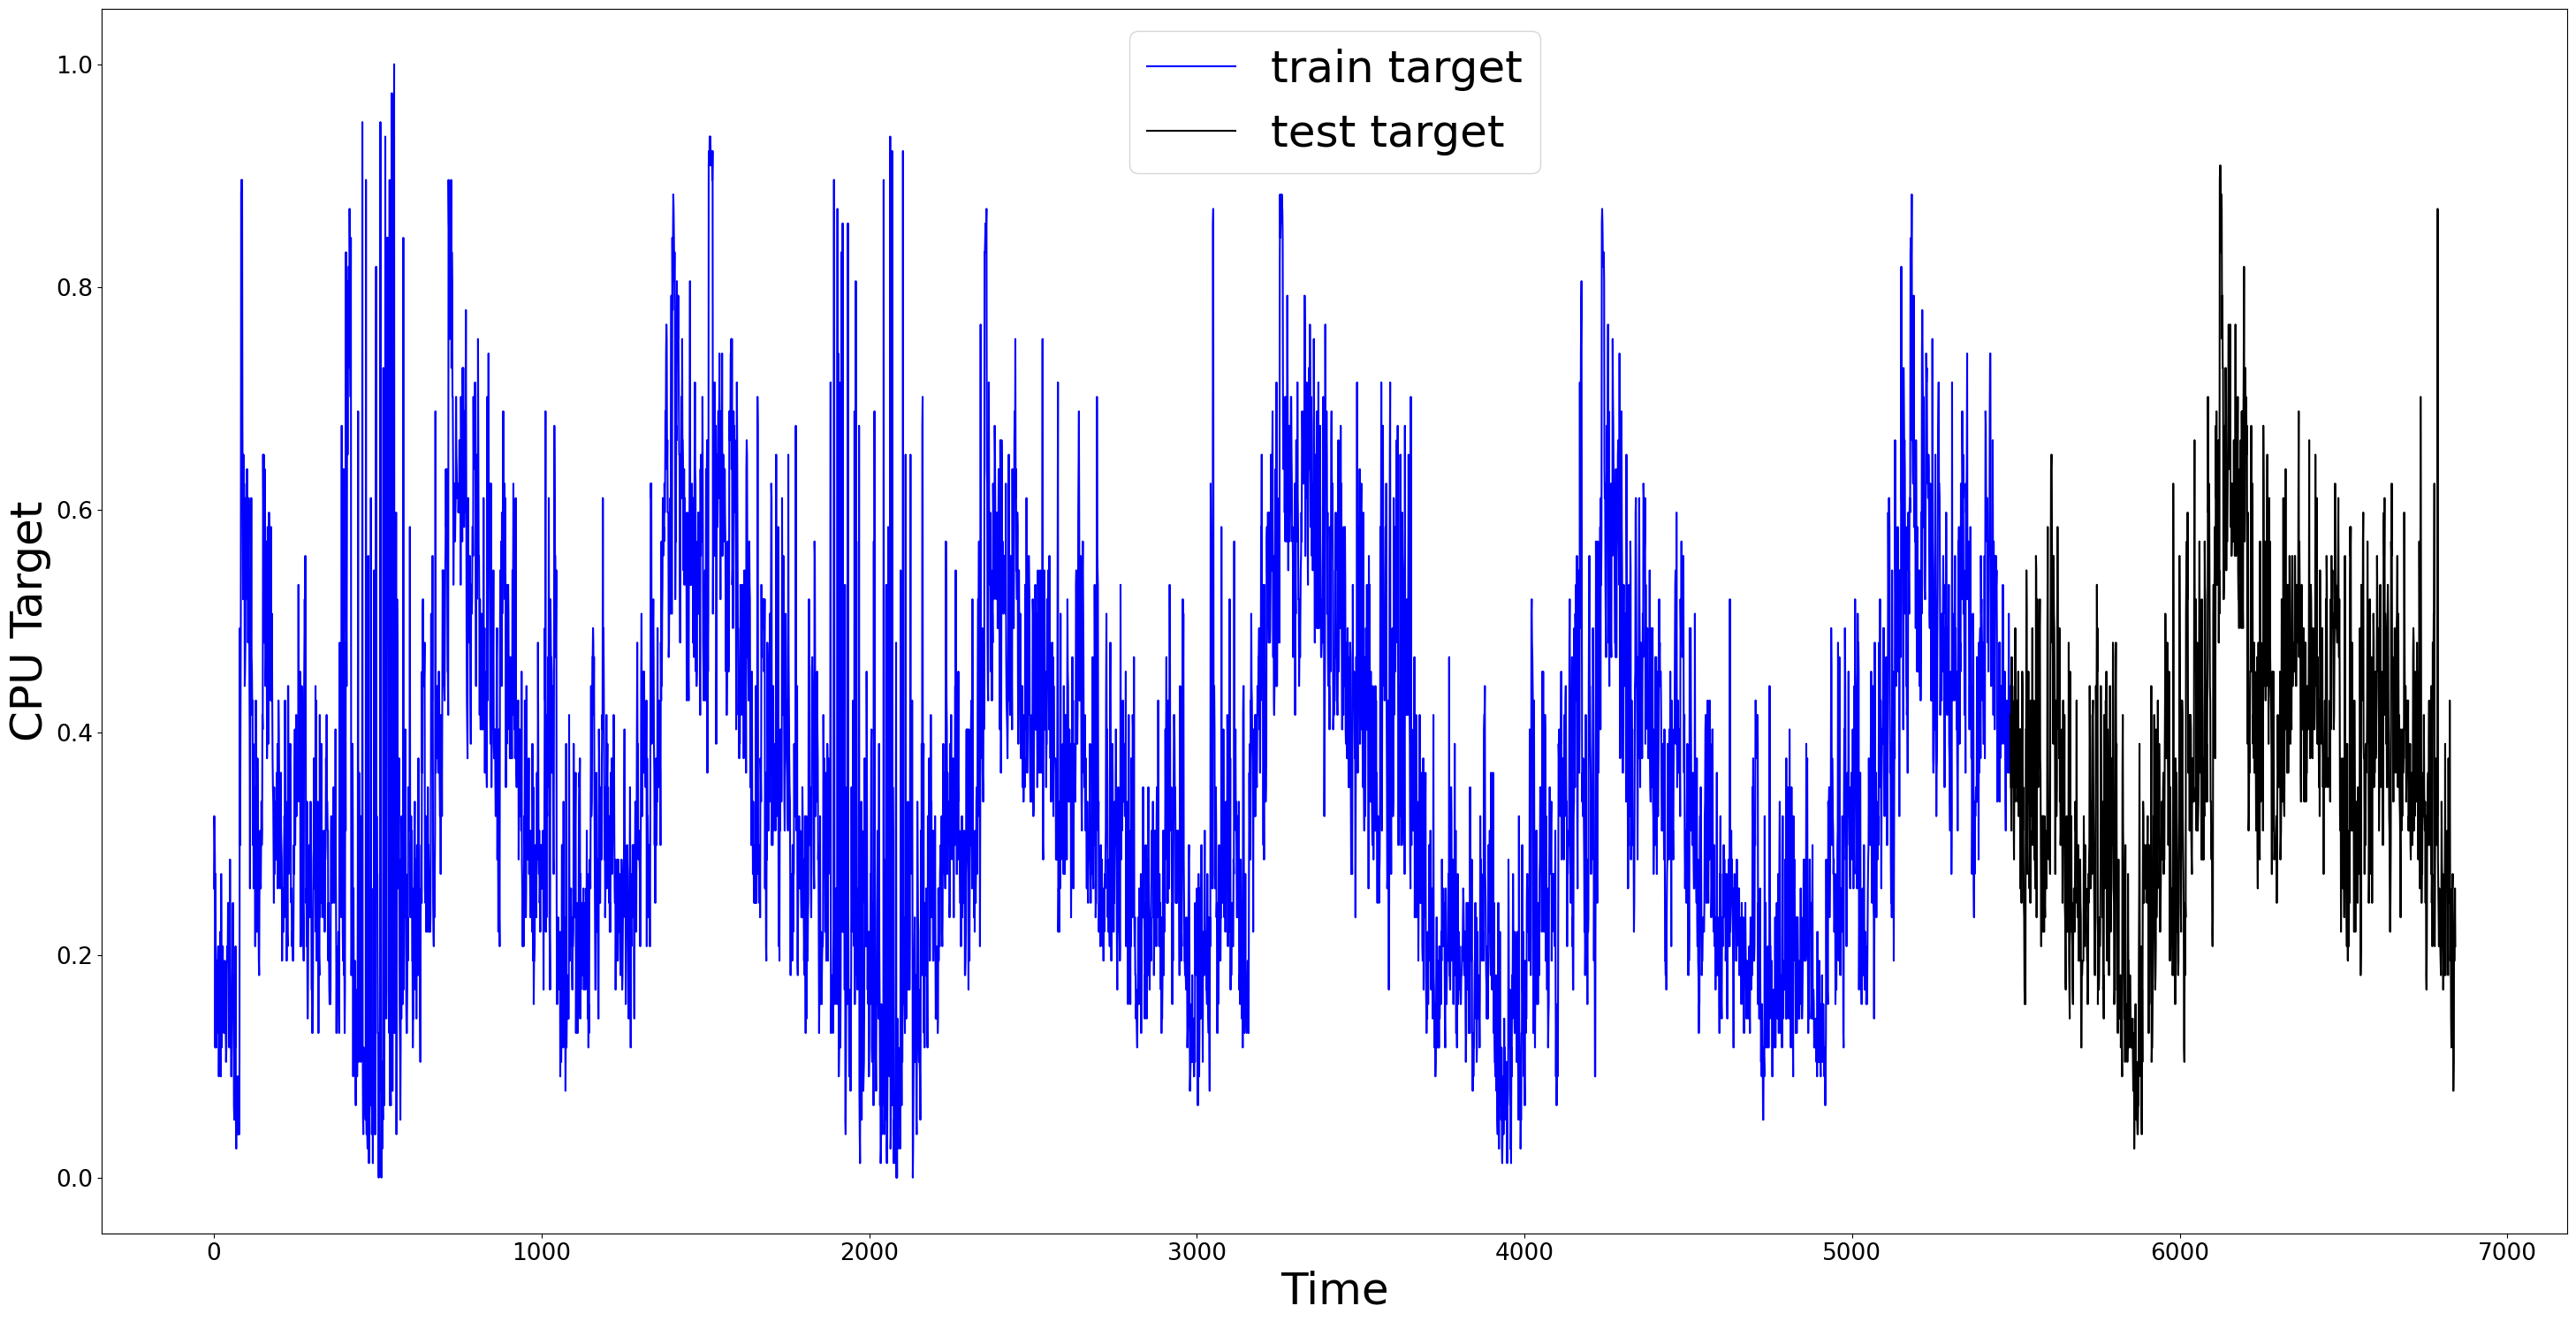

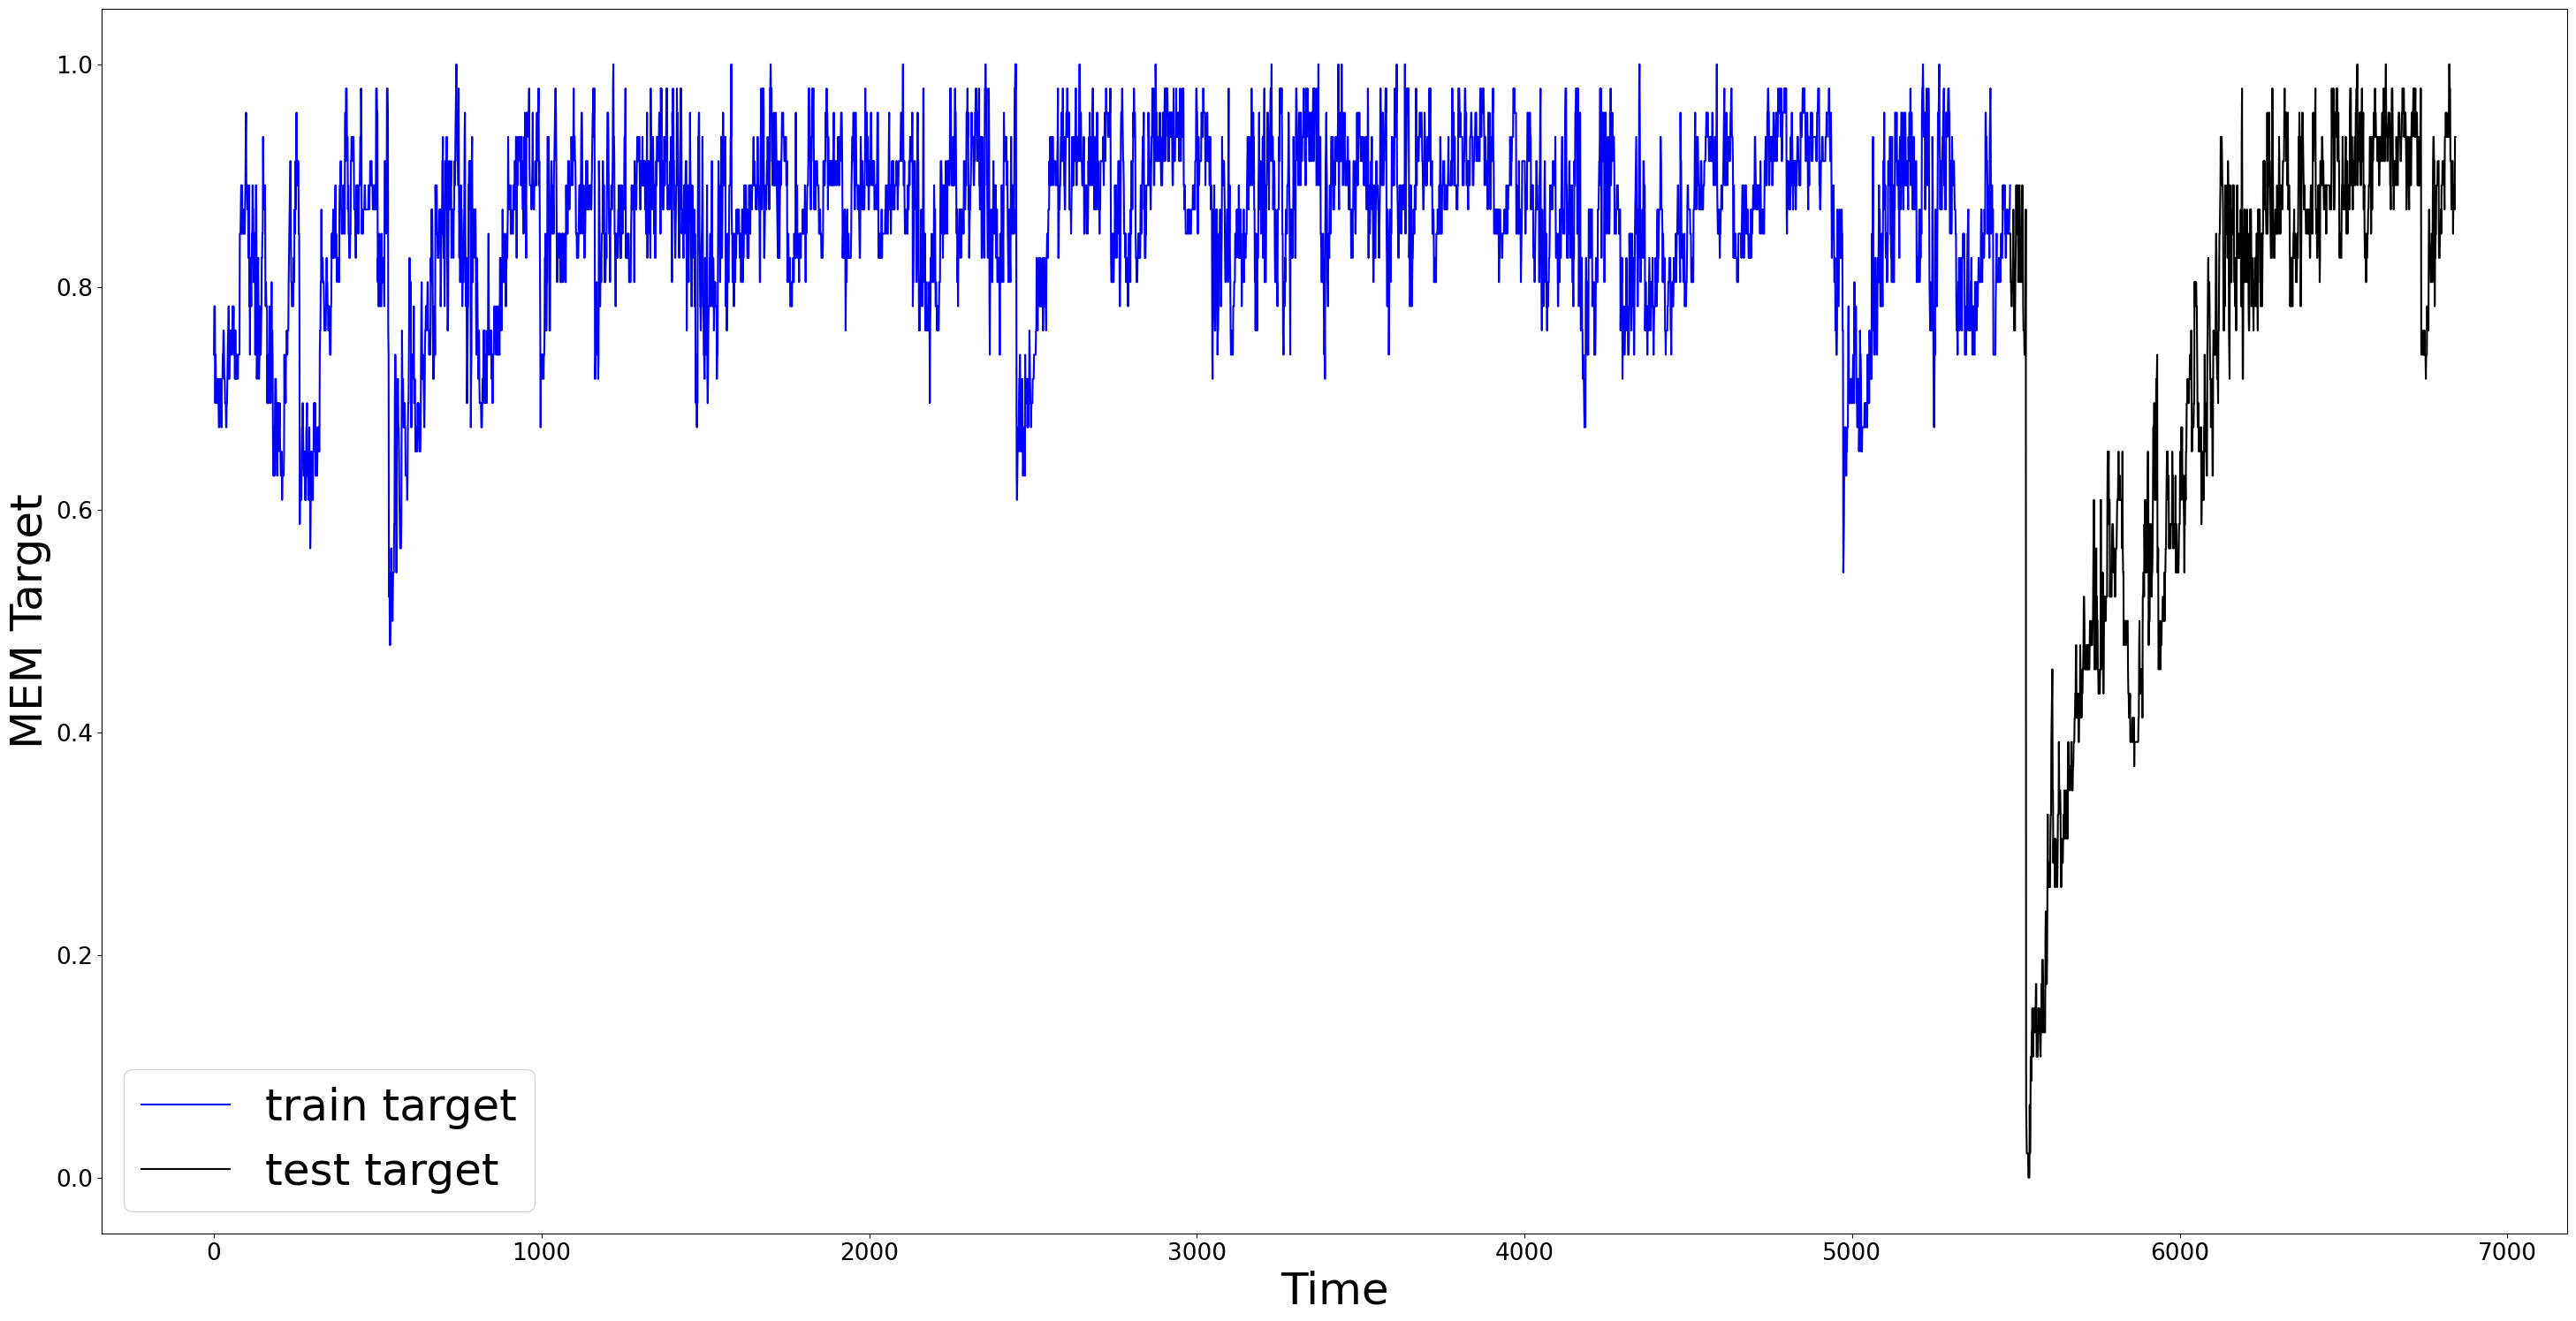

In [8]:
times1 = int(train_y.shape[0])    #训练集的时间序列大小 
times2 = int(test_y.shape[0])      #测试集的时间序列大小 
def plot_data(Time1,    
              Time2, 
              train_y: numpy.ndarray,    #训练集上的预测值
              test_y: numpy.ndarray,     #测试集上的预测值。
              X: str,
              Y: str):#整个数据集上的预测值。

    plt.figure(figsize = (36,18))
    plt.tick_params(labelsize=19)
    #plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
    #给当前图表添加一个 x 轴标签，标签内容为 'Date_Time'，字体大小为 18。
    plt.xlabel(X,fontsize=36)
    #给当前图表添加一个 y 轴标签，标签内容为 'Close Price'，字体大小为 18。
    plt.ylabel(Y,fontsize=36)
    #展示了预测结果和原始数据的对比。
    #原始数据的折线图
    #训练数据的预测结果的折线图，其横坐标的前look_back个点为空，因为模型在这个时候还没有进行预测
    plt.plot(range(Time1), [x for x in train_y],color='blue', label='train target')
    #测试数据的预测结果的折线图，它的横坐标与第二条曲线重合，前面也是有look_back个点为空的。
    plt.plot(range(Time1+Time2), 
             [None for _ in train_y] +
             [x for x in test_y],color='black', label='test target')
    plt.legend(loc='best',fontsize=36)
    plt.show()
#CPU
plot_data(times1,times2,train_y,test_y,"Time","CPU Target")
#MEM
plot_data(times1,times2,train_y2,test_y2,"Time","MEM Target")

In [9]:
class TransformerEncoder(layers.Layer):
    def __init__(self,
                 head_size, 
                 num_heads, 
                 ff_dim,
                 dropout=0
                ):
        super(TransformerEncoder, self).__init__()
        self.head_size = head_size
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout = dropout
        
        self.layer_norm_1 = layers.LayerNormalization(epsilon=1e-6)
        self.multihead_attention = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )
        self.dropout_1 = layers.Dropout(0.25)
        self.layer_norm_2 = layers.LayerNormalization(epsilon=1e-6)
        self.conv1d_1 = layers.Conv1D(filters=4, kernel_size=1, activation="relu")    #filters:过滤器的个数   kernel:核数
        self.dropout_2 = layers.Dropout(0.2)
        self.conv1d_2 = layers.Conv1D(filters=1, kernel_size=1)

    def call(self, inputs):
        # Normalization and Attention
#         print(inputs.shape)
        x = self.layer_norm_1(inputs)
#         x = tf.expand_dims(x,axis=1)
        attention_output = self.multihead_attention(x, x)
        x = self.dropout_1(attention_output)
        res = x + inputs

        # Feed Forward Part
        x = self.layer_norm_2(res)
        x = self.conv1d_1(x)

        x = self.dropout_2(x)
        x = self.conv1d_2(x)
        output = x + res
        
        return output

In [10]:
class attention(layers.Layer):
    def __init__(self,
                 att_size, 
                 att_heads, 
                 att_ff_dim,
                 att_dropout=0
                ):
        super(attention, self).__init__()
        self.head_size = att_size
        self.num_heads = att_heads
        self.ff_dim = att_ff_dim
        self.dropout = att_dropout
        
        self.layer_norm_1 = layers.LayerNormalization(epsilon=1e-6)
        self.multihead_attention = layers.MultiHeadAttention(
            key_dim=att_size, num_heads=att_heads, dropout=att_dropout
        )
        self.dropout_1 = layers.Dropout(0.25)
        self.layer_norm_2 = layers.LayerNormalization(epsilon=1e-6)
        self.conv1d_1 = layers.Conv1D(filters=4, kernel_size=1, activation="relu")
        self.dropout_2 = layers.Dropout(0.2)
        self.conv1d_2 = layers.Conv1D(filters=1, kernel_size=1)

    def call(self, inputs1, inputs2):
        # Normalization and Attention
#         print(inputs.shape)
#         x1 = self.layer_norm_1(inputs1)
#         x2 = self.layer_norm_1(inputs2)
        x1 = inputs1
        x2 = inputs2
#         print(x1.shape)
#         print(x2.shape)
#         x = tf.expand_dims(x,axis=1)
        attention_output = self.multihead_attention(x1, x2)
#         print(attention_output.shape)
        # 进行加权平均
#         weighted_average = tf.reduce_sum(attention_output* x2)
#         weighted_average = tf.reduce_sum(tf.multiply(attention_output, x2), axis=1)
        weighted_average = tf.multiply(attention_output, x2) + x1

#         print(weighted_average.shape)
#         #特征融合
#         x = weighted_average + x1
#         print(x.shape)
        output = weighted_average
        # Feed Forward Part
        x = self.layer_norm_2(output)
        x = self.conv1d_1(x)

        x = self.dropout_2(x)
        x = self.conv1d_2(x)
        output = x + output
#         print(output.shape) 
        return output

In [11]:
class LSTMDecoder(layers.Layer):
    def __init__(self, hidden_size):
        super(LSTMDecoder, self).__init__()
        self.hidden_size = hidden_size
#         self.input_size = input_size
     
        # 创建LSTM模型
        self.Lstm1 = layers.LSTM(units = hidden_size,return_sequences=True)
        self.Dropout1 = layers.Dropout(0.2)
        self.Lstm2 = layers.LSTM(units= hidden_size,return_sequences=True)
        self.Dropout2 = layers.Dropout(0.2)
        self.Lstm3 = layers.LSTM(units = hidden_size,return_sequences=True)
        self.Dropout3 = layers.Dropout(0.2)
        self.Dense = layers.Dense(units = SEQ_LEN, activation='relu')
    def call(self, inputs):
        # 将输入通过LSTM模型
        x1 = self.Lstm1(inputs)
        x = self.Dropout1(x1)
        x2 = self.Lstm2(x)
        x = self.Lstm3(x1+x2)
        output = self.Dense(x)
        #x = self.Dense(x[:,-1,:])
        return output

In [16]:
def build_model():
    inp1 = Input(shape = (16,1))
    inp2 = Input(shape = (16,1))
    x1 = TransformerEncoder(head_size=256, num_heads=4, ff_dim=4, dropout=0.2)(inp1)
    x2 = TransformerEncoder(head_size=256, num_heads=4, ff_dim=4, dropout=0.2)(x1)
    x3 = TransformerEncoder(head_size=256, num_heads=4, ff_dim=4, dropout=0.2)(x2)
    x5 = TransformerEncoder(head_size=256, num_heads=4, ff_dim=4, dropout=0.2)(inp2)
    x6 = TransformerEncoder(head_size=256, num_heads=4, ff_dim=4, dropout=0.2)(x5)
    x7 = TransformerEncoder(head_size=256, num_heads=4, ff_dim=4, dropout=0.2)(x6)
    x = attention(att_size=256, att_heads=4, att_ff_dim=4, att_dropout=0.2)(x3,x7)
    x = LSTMDecoder(hidden_size=128)(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    x = Dense(128, activation="relu")(conc)
    x = Dense(1, activation="sigmoid")(x) 
    model = Model(inputs=[inp1, inp2], outputs = x)
    model.compile(
        loss = "mean_squared_error",  
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-4))

    return model

In [17]:
model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 16, 1)]      0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 16, 1)]      0           []                               
                                                                                                  
 transformer_encoder_6 (Transfo  (None, 16, 1)       7186        ['input_3[0][0]']                
 rmerEncoder)                                                                                     
                                                                                                  
 transformer_encoder_9 (Transfo  (None, 16, 1)       7186        ['input_4[0][0]']          

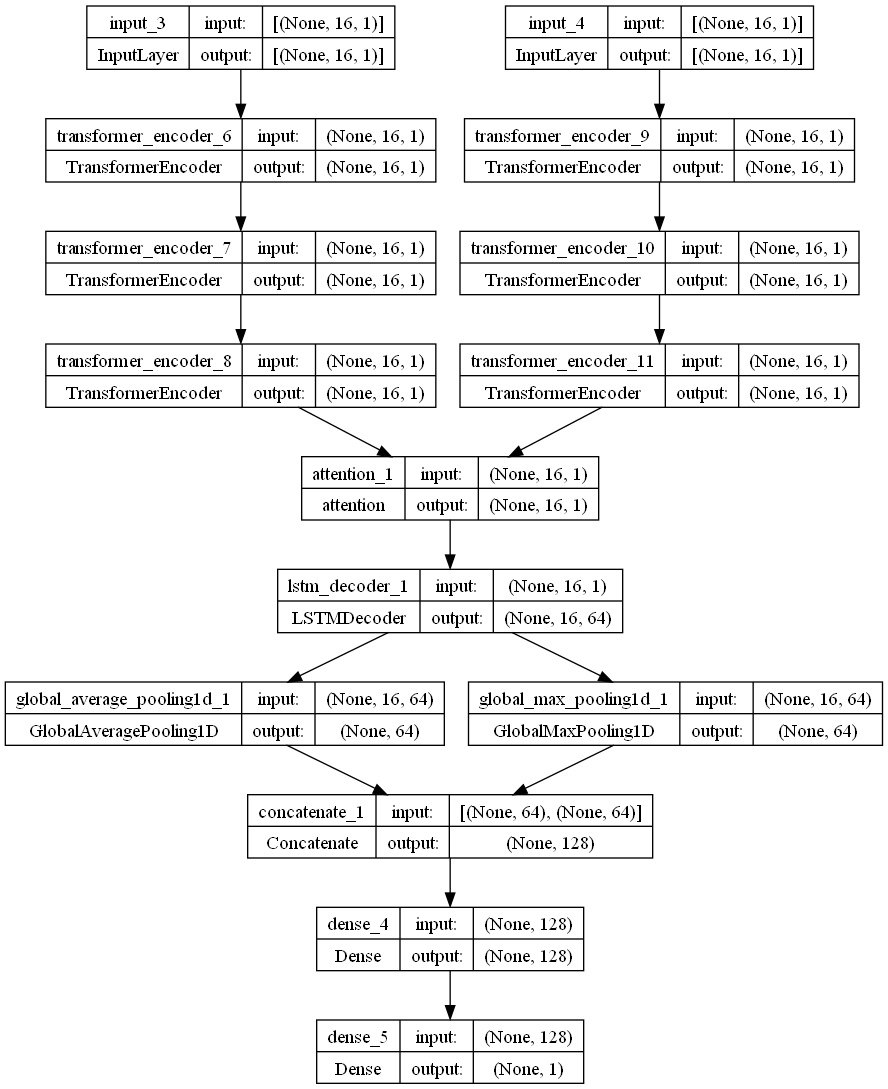

In [18]:
tf.keras.utils.plot_model(model, 
                          to_file="multi_head_net.png", 
                          show_shapes=True)

In [36]:
model.fit(
    [train_x, train_x2],  # 输入数据的列表，与模型的输入层顺序对应
    train_y,              # 目标数据（标签）
    validation_split=0.2,
    epochs=150,
    batch_size=64,

)

Epoch 1/150
69/69 [==============================] - 35s 291ms/step - loss: 0.0342 - val_loss: 0.0287
Epoch 2/150
69/69 [==============================] - 17s 252ms/step - loss: 0.0322 - val_loss: 0.0268
Epoch 3/150
69/69 [==============================] - 18s 264ms/step - loss: 0.0318 - val_loss: 0.0242
Epoch 4/150
69/69 [==============================] - 18s 254ms/step - loss: 0.0292 - val_loss: 0.0185
Epoch 5/150
69/69 [==============================] - 18s 258ms/step - loss: 0.0228 - val_loss: 0.0105
Epoch 6/150
69/69 [==============================] - 18s 260ms/step - loss: 0.0196 - val_loss: 0.0114
Epoch 7/150
69/69 [==============================] - 18s 255ms/step - loss: 0.0186 - val_loss: 0.0097
Epoch 8/150
69/69 [==============================] - 17s 252ms/step - loss: 0.0174 - val_loss: 0.0088
Epoch 9/150
69/69 [==============================] - 18s 254ms/step - loss: 0.0172 - val_loss: 0.0088
Epoch 10/150
69/69 [==============================] - 17s 253ms/step - loss: 0.016

In [37]:
model.save_weights('./checkpoints/final_checkpoint_150')

In [19]:
model.load_weights('./checkpoints/final_checkpoint_150')

In [20]:
#使用多头模型 multi_head 对测试集 X_test 进行预测得到的预测结果。

predicted_CPU = model.predict([test_x,test_x])
predicted_CPU.shape

43/43 [==============================] - 5s 62ms/step


(1359, 1)

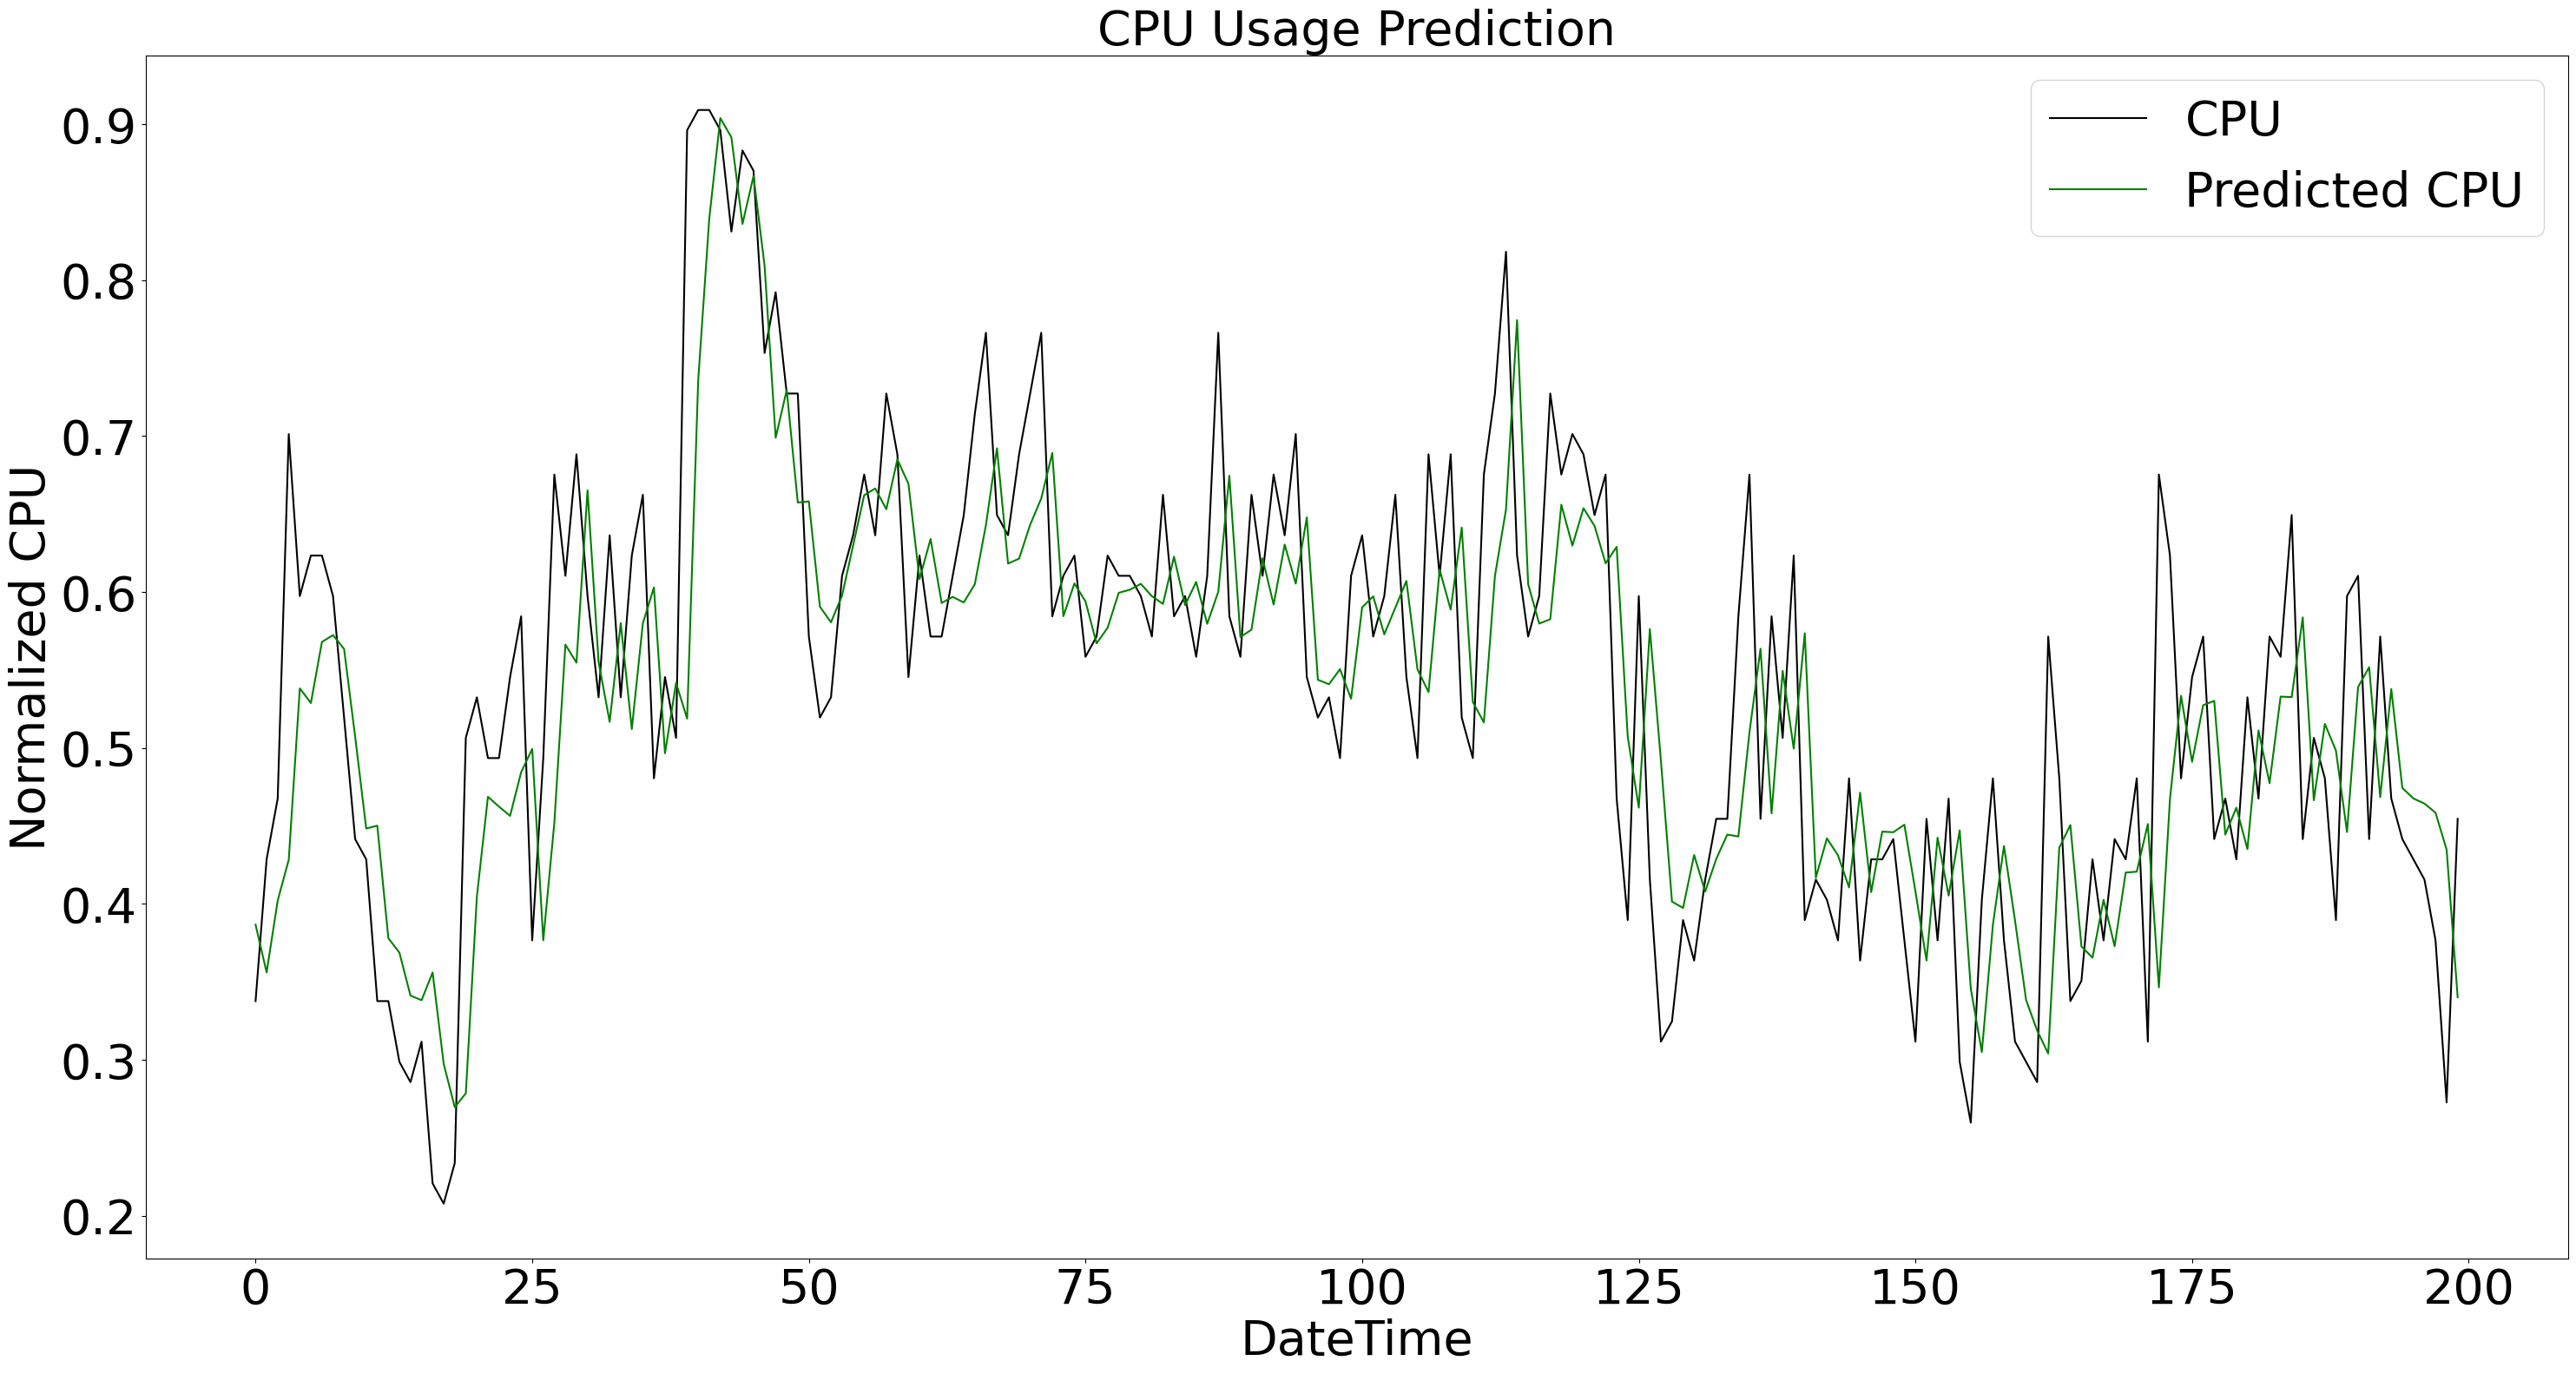

In [32]:
plt.figure(figsize = (36,18))
plt.plot(test_y[600:800], color = 'black', label = 'CPU')
plt.plot(predicted_CPU[600:800], color = 'green', label = 'Predicted CPU')
plt.title('CPU Usage Prediction', fontsize=40)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime',fontsize=40)
plt.xticks(fontsize=40)
plt.ylabel('Normalized CPU',fontsize=40)
plt.yticks(fontsize=40)
plt.legend(fontsize=40, loc='upper right')
plt.show()

In [33]:
train_data , test_data = split_dataset(dataset_1 , 0.8)
Test_x,Test_y = create_dataset(test_data)
Test_y

train_dataset: 5499, test_dataset: 1375


array([47., 42., 42., ..., 30., 35., 31.], dtype=float32)

In [34]:
predicted_y = scaler_1.inverse_transform(predicted_CPU)
print(predicted_y)

[[43.5714  ]
 [47.26005 ]
 [44.51244 ]
 ...
 [32.237816]
 [31.523134]
 [32.413246]]


In [35]:
test_score = numpy.sqrt(mean_squared_error(Test_y[:], predicted_y[:, 0]))
print('Test Score: %.2f RMSE' % test_score)

Test Score: 6.58 RMSE


In [37]:
# MAE, 平均绝对误差（  （|预测| - |真实| ）/ 样本个数   ）
from sklearn.metrics import mean_absolute_error
test_score = mean_absolute_error(Test_y, predicted_y[:,0])
print('Test Score: %.2f MAE' % test_score)
#MSLE, 均方对数误差  MSLE = mean((log(1 + y_pred) - log(1 + y_true))²)
#衡量预测结果与真实值之间的对数差异程度的平均值
from sklearn.metrics import mean_squared_log_error
test_score = mean_squared_log_error(Test_y, predicted_y[:,0])
print('Test Score: %.2f MSLE' % test_score)
#R-Squared (决定系数)：R-Squared = 1 - (SSR / SST)  
from sklearn.metrics import r2_score
test_score = r2_score(Test_y, predicted_y[:,0])
print('Test Score: %.2f R^2' % test_score)
#Mean Absolute Percentage Error (MAPE, 平均绝对百分比误差)：
test_score = numpy.mean(numpy.abs((Test_y - predicted_y[:,0]) / Test_y)) * 100
print('Test Score: %.2f%% MAPE' % test_score)
# Mean Percentage Error (MPE, 平均百分比误差)：  特别适用于时间序列数据
#MPE的取值范围是负无穷到正无穷，正值表示预测结果高估，负值表示预测结果低估，0表示预测结果准确。
test_score = numpy.mean((Test_y - predicted_y[:,0]) / Test_y) * 100
print('Test Score: %.2f%% MPE' % test_score)
#相对绝对误差（RAE）：
#RAE的值越小越好，它衡量了模型预测误差与基准模型预测误差的相对性。
def relative_absolute_error(actual_values, predicted_values):
    absolute_errors = numpy.abs(actual_values - predicted_values)
    mean_actual = numpy.mean(actual_values)
    return numpy.sum(absolute_errors) / numpy.sum(numpy.abs(actual_values - mean_actual))
rae = relative_absolute_error(Test_y, predicted_y[:,0])
print('Test Score: %.2f%% RAE' % rae)
#Median Absolute Error (MedAE, 中位数绝对误差)：
#中位数绝对误差的值越小，表示模型的预测误差越小，模型的性能越好。
from sklearn.metrics import median_absolute_error
test_score = median_absolute_error(Test_y, predicted_y[:,0])
print('Test Score: %.2f MedAE' % test_score)

Test Score: 4.97 MAE
Test Score: 0.02 MSLE
Test Score: 0.64 R^2
Test Score: 11.84% MAPE
Test Score: -2.41% MPE
Test Score: 0.57% RAE
Test Score: 3.93 MedAE
